In [ ]:
# Install dependencies
# !pip install Cython
# !pip install --upgrade --force-reinstall gensim
# nltk.download('punkt_tab')
# nltk.download('punkt')

import pandas as pd
import re
import nltk
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import seaborn as sns
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
import re

1. Przeprowadzić analizę podobieństwa wybranych rozdziałów
Wybrać po kilka rozdziałów z „Anna Karenina” i „Jane Eyre” i przeanalizować ich podobieństwo za pomocą metod opartych na wektorach tekstu (np. TF-IDF lub Word2Vec). Określić, które rozdziały wykazują największe podobieństwo pod względem stylu lub treści.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


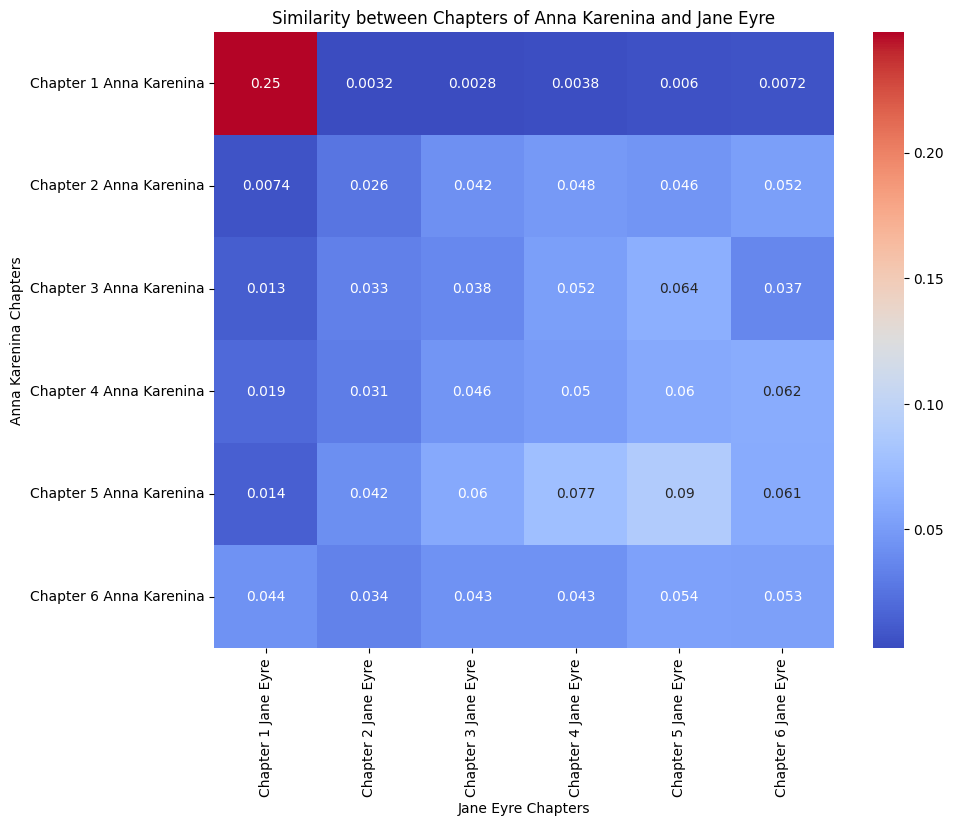

Highest similarity is between Chapter 1 of Anna Karenina and Chapter 1 of Jane Eyre, with a similarity score of 0.2480


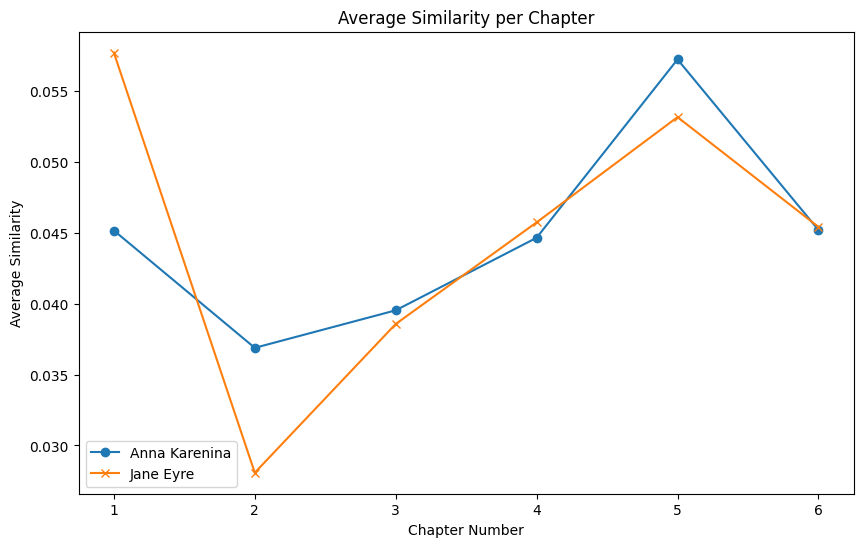

In [9]:


with open('anna_karenina.txt', 'r', encoding='utf-8') as file_anna:
    anna_karenina_content = file_anna.read()

with open('jane_eyre.txt', 'r', encoding='utf-8') as file_jane:
    jane_eyre_content = file_jane.read()

def split_text_into_chapters(text):
    chapter_identifier = r"(?:CHAPTER\s+[IVXLCDM]+|Chapter\s+\d+)"
    chapters = re.split(chapter_identifier, text, flags=re.IGNORECASE)
    return [chapter.strip() for chapter in chapters if chapter.strip()]

anna_chapters = split_text_into_chapters(anna_karenina_content)
jane_chapters = split_text_into_chapters(jane_eyre_content)

selected_anna_chapters = anna_chapters[:6]
selected_jane_chapters = jane_chapters[:6]

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

def preprocess_text_data(text):
    cleaned_text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(cleaned_text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return filtered_tokens

preprocessed_anna = [preprocess_text_data(chapter) for chapter in selected_anna_chapters]
preprocessed_jane = [preprocess_text_data(chapter) for chapter in selected_jane_chapters]

combined_texts = preprocessed_anna + preprocessed_jane
text_dictionary = Dictionary(combined_texts)

corpus_anna_bow = [text_dictionary.doc2bow(text) for text in preprocessed_anna]
corpus_jane_bow = [text_dictionary.doc2bow(text) for text in preprocessed_jane]

tfidf_model = TfidfModel(corpus_anna_bow + corpus_jane_bow)

tfidf_anna = [tfidf_model[doc] for doc in corpus_anna_bow]
tfidf_jane = [tfidf_model[doc] for doc in corpus_jane_bow]

similarity_index = MatrixSimilarity(tfidf_jane, num_features=len(text_dictionary))

similarity_matrix = np.zeros((len(tfidf_anna), len(tfidf_jane)))

for i, anna_doc in enumerate(tfidf_anna):
    similarity_scores = similarity_index[anna_doc]
    similarity_matrix[i] = similarity_scores

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", cbar=True,
            xticklabels=[f'Chapter {i+1} Jane Eyre' for i in range(len(selected_jane_chapters))],
            yticklabels=[f'Chapter {i+1} Anna Karenina' for i in range(len(selected_anna_chapters))])
plt.title("Similarity between Chapters of Anna Karenina and Jane Eyre")
plt.xlabel("Jane Eyre Chapters")
plt.ylabel("Anna Karenina Chapters")
plt.show()

highest_similarity = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
highest_value = similarity_matrix[highest_similarity]
print(f"Highest similarity is between Chapter {highest_similarity[0]+1} of Anna Karenina and Chapter {highest_similarity[1]+1} of Jane Eyre, with a similarity score of {highest_value:.4f}")

avg_similarity_anna = np.mean(similarity_matrix, axis=1)
avg_similarity_jane = np.mean(similarity_matrix, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selected_anna_chapters) + 1), avg_similarity_anna, label='Anna Karenina', marker='o')
plt.plot(range(1, len(selected_jane_chapters) + 1), avg_similarity_jane, label='Jane Eyre', marker='x')
plt.title("Average Similarity per Chapter")
plt.xlabel("Chapter Number")
plt.ylabel("Average Similarity")
plt.legend()
plt.show()



2. Zbudować osadzenia słów i porównać użycie wybranych terminów
Wygenerować osadzenia słów (np. Word2Vec) dla obu książek i porównać, jak wybrane słowa (np. „miłość”, „małżeństwo”, „rodzina”) są reprezentowane w każdej z nich. Wykorzystać podobieństwo kosinusowe, aby zobaczyć, jak bliskie są te słowa względem innych wyrazów.

In [17]:


def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    tokens = text.split()
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def train_word2vec_model(sentences, vector_size=300, window=10, min_count=1,workers=3, epochs=15, sg=0):
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=4
    )
    return model

anna_model_full = train_word2vec_model(preprocessed_anna)
jane_model_full = train_word2vec_model(preprocessed_jane)

def get_most_similar_words(model, word, num_results=5):
    try:
        similar_words = model.wv.most_similar(word, topn=num_results)
        return similar_words
    except KeyError:
        return f"'{word}' not found in model."

def compute_cosine_similarity_between_models(word, model1, model2):
    try:
        vector1 = model1.wv[word].reshape(1, -1)
        vector2 = model2.wv[word].reshape(1, -1)
        return cosine_similarity(vector1, vector2)[0][0]
    except KeyError:
        return f"'{word}' not found in both models."

words_to_analyze = ["love", "marriage", "family"]

for word in words_to_analyze:
    print(f"\nWords similar to '{word}' in 'Anna Karenina':")
    print(get_most_similar_words(anna_model_full, word))

    print(f"\nWords similar to '{word}' in 'Jane Eyre':")
    print(get_most_similar_words(jane_model_full, word))

print("\nCosine similarity between word vectors in 'Anna Karenina' and 'Jane Eyre':")
for word in words_to_analyze:
    similarity = compute_cosine_similarity_between_models(word, anna_model_full, jane_model_full)
    print(f"Cosine similarity for '{word}': {similarity}")



Words similar to 'love' in 'Anna Karenina':
[('one', 0.21796278655529022), ('father', 0.2107442170381546), ('face', 0.20613619685173035), ('come', 0.20209631323814392), ('make', 0.20192721486091614)]

Words similar to 'love' in 'Jane Eyre':
[('returned', 0.2827431559562683), ('nothing', 0.2822284400463104), ('good', 0.2694627344608307), ('mr', 0.2577049136161804), ('never', 0.257102906703949)]

Words similar to 'marriage' in 'Anna Karenina':
[('upstairs', 0.21047918498516083), ('tearing', 0.1982758492231369), ('feeling', 0.17294219136238098), ('straight', 0.16825534403324127), ('memory', 0.16584499180316925)]

Words similar to 'marriage' in 'Jane Eyre':
'marriage' not found in model.

Words similar to 'family' in 'Anna Karenina':
[('embraced', 0.22707244753837585), ('excellent', 0.21783873438835144), ('boardroom', 0.18312540650367737), ('petticoats', 0.18152035772800446), ('soup', 0.17994439601898193)]

Words similar to 'family' in 'Jane Eyre':
[('bid', 0.23049120604991913), ('curtain

3. Stworzyć model klasyfikacji toksyczności przy użyciu wektorów
Korzystając z Gensim, wygenerować wektory tekstowe (np. TF-IDF) dla komentarzy, a następnie użyć modelu uczenia maszynowego do klasyfikacji toksycznych i nietoksycznych treści.

Liczba toksycznych komentarzy: 811
Liczba nietoksycznych komentarzy: 9189


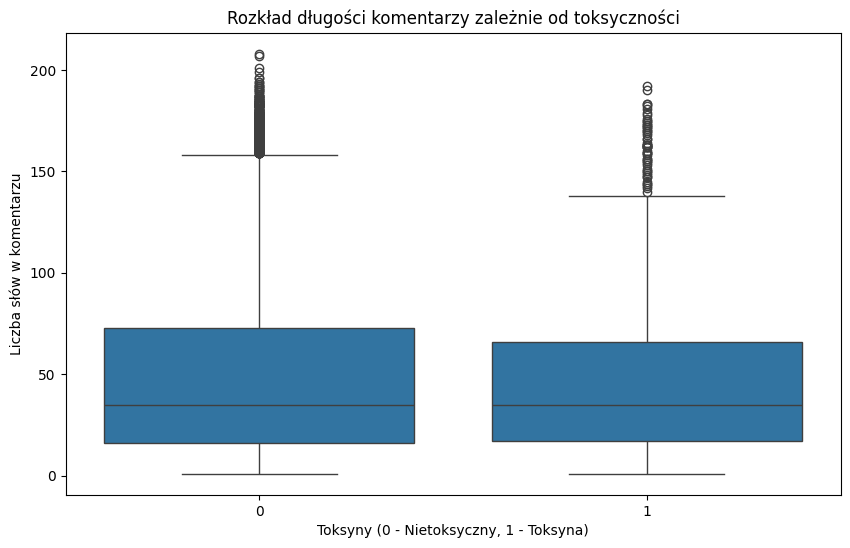

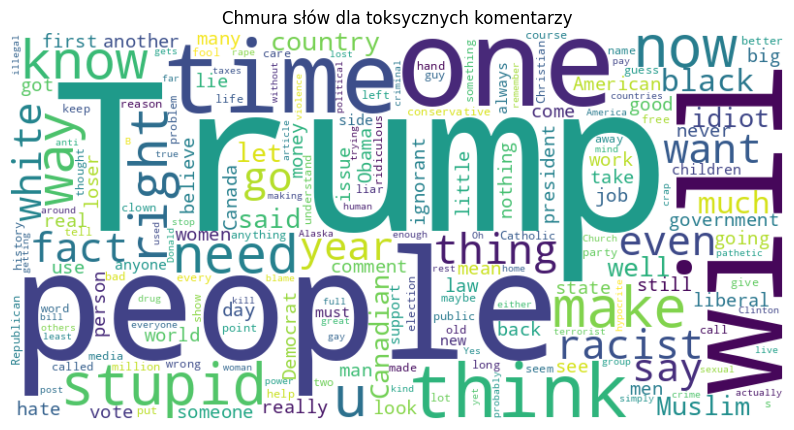

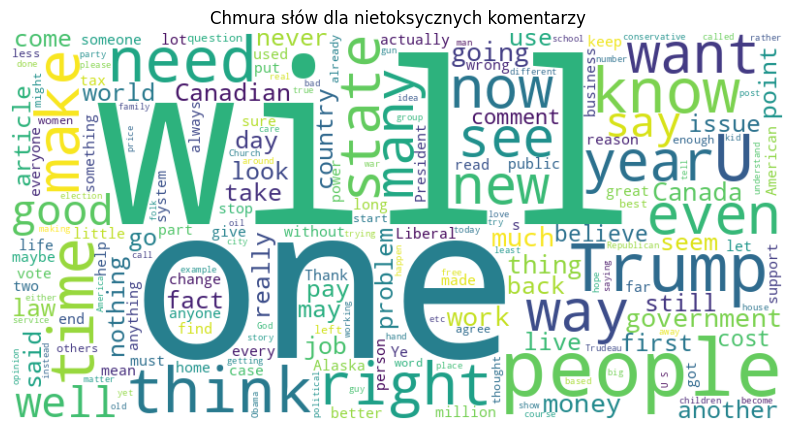

Dokładność modelu: 0.9330

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2768
           1       0.86      0.16      0.27       232

    accuracy                           0.93      3000
   macro avg       0.90      0.58      0.62      3000
weighted avg       0.93      0.93      0.91      3000



<ipython-input-20-4c70e465c180>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette='coolwarm')


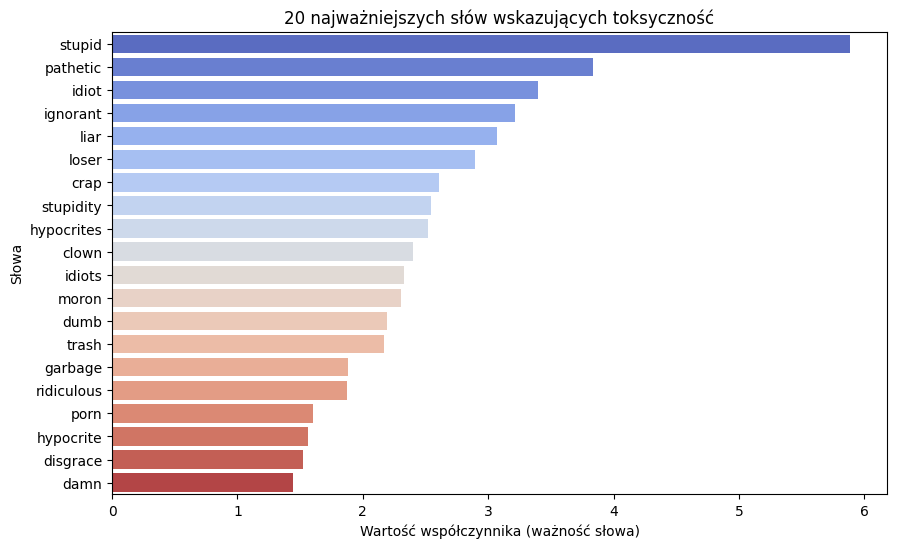

<ipython-input-20-4c70e465c180>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='Set2')


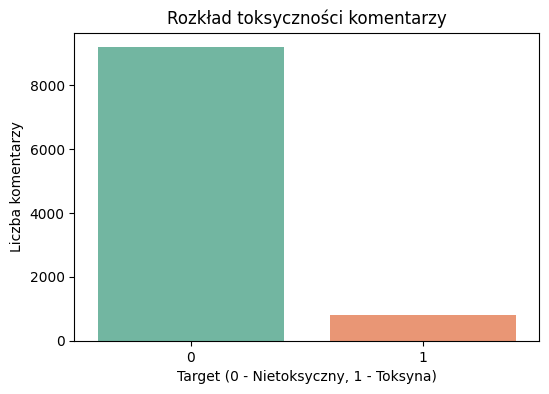

In [20]:


df = pd.read_csv("sample.csv")
df['target'] = df['target'].apply(lambda x: 1 if x > 0.4 else 0)

print(f"Liczba toksycznych komentarzy: {df[df['target'] == 1].shape[0]}")
print(f"Liczba nietoksycznych komentarzy: {df[df['target'] == 0].shape[0]}")

df['comment_length'] = df['comment_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='comment_length', data=df)
plt.title("Rozkład długości komentarzy zależnie od toksyczności")
plt.xlabel("Toksyny (0 - Nietoksyczny, 1 - Toksyna)")
plt.ylabel("Liczba słów w komentarzu")
plt.show()

toxic_comments = df[df['target'] == 1]['comment_text']
non_toxic_comments = df[df['target'] == 0]['comment_text']

def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text_data))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(toxic_comments, "Chmura słów dla toksycznych komentarzy")

generate_wordcloud(non_toxic_comments, "Chmura słów dla nietoksycznych komentarzy")

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['comment_text'])

X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.3, random_state=42)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print(f"Dokładność modelu: {accuracy_score(y_test, y_pred):.4f}")
print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred))

coefficients = svm_model.coef_.toarray().flatten()
feature_names = np.array(vectorizer.get_feature_names_out())

sorted_idx = np.argsort(coefficients)[::-1]
top_n = 20  # Najlepsze 20 słów
top_features = feature_names[sorted_idx][:top_n]
top_coeffs = coefficients[sorted_idx][:top_n]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_coeffs, y=top_features, palette='coolwarm')
plt.title("20 najważniejszych słów wskazujących toksyczność")
plt.xlabel("Wartość współczynnika (ważność słowa)")
plt.ylabel("Słowa")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Rozkład toksyczności komentarzy")
plt.xlabel("Target (0 - Nietoksyczny, 1 - Toksyna)")
plt.ylabel("Liczba komentarzy")
plt.show()


4. Stworzyć słownik toksycznych słów i porównać go z nietoksycznymi
Na podstawie komentarzy stworzyć słownik wyrazów lub fraz, które występują częściej w toksycznych komentarzach. Użyć podobieństwa słów (Word2Vec) do poszukiwania innych słów o podobnej toksycznej wymowie.

In [24]:
import pandas as pd
import numpy as np
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv("sample.csv")
df['target'] = df['target'].apply(lambda x: 1 if x > 0.4 else 0)

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  # Usunięcie znaków specjalnych
    tokens = word_tokenize(text.lower())  # Tokenizacja i zamiana na małe litery
    tokens = [word for word in tokens if word not in stop_words]  # Usuwanie stop słów
    return tokens

df['processed_text'] = df['comment_text'].apply(preprocess_text)
toxic_comments = df[df['target'] == 1]['processed_text']
non_toxic_comments = df[df['target'] == 0]['processed_text']

all_comments = toxic_comments.tolist() + non_toxic_comments.tolist()  # Łączenie obu zbiorów
model = Word2Vec(sentences=all_comments, vector_size=100, window=5, min_count=2, sg=1)

toxic_words = [word for comment in toxic_comments for word in comment]
non_toxic_words = [word for comment in non_toxic_comments for word in comment]

toxic_word_freq = Counter(toxic_words)
non_toxic_word_freq = Counter(non_toxic_words)

toxic_dict = {word: freq for word, freq in toxic_word_freq.items() if freq > 2}
non_toxic_dict = {word: freq for word, freq in non_toxic_word_freq.items() if freq > 2}

def get_similar_words(model, word, topn=5):
    if word in model.wv:
        return model.wv.most_similar(word, topn=topn)
    else:
        return []

example_words = list(toxic_dict.keys())[:5]
for word in example_words:
    print(f"\nSłowa podobne do '{word}' (toksyczne):")
    similar_words = get_similar_words(model, word)
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity}")

toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(toxic_dict)
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_toxic_dict)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Słowa podobne do 'jewish' (toksyczne):
assault: 0.9804625511169434
armed: 0.9782938957214355
nazi: 0.9778741002082825
nazis: 0.9767168164253235
sexual: 0.976655900478363

Słowa podobne do 'friends' (toksyczne):
rules: 0.9808734655380249
notice: 0.9805686473846436
sometimes: 0.9801203012466431
dog: 0.9798916578292847
imagine: 0.9796833992004395

Słowa podobne do 'ones' (toksyczne):
serve: 0.9915762543678284
offer: 0.9913370013237
ordinary: 0.991298258304596
streets: 0.9903024435043335
parent: 0.989241361618042

Słowa podobne do 'told' (toksyczne):
sentence: 0.9822080135345459
waiting: 0.9788814783096313
ball: 0.9778570532798767
worked: 0.9763041734695435
friend: 0.9758424758911133

Słowa podobne do 'control' (toksyczne):
economic: 0.9463471174240112
security: 0.944294810295105
protect: 0.94356369972229
quebec: 0.9405918717384338
allow: 0.939973771572113
